## DAY2
kickstarter Project for Kaggle　　https://www.kaggle.com/kemical/kickstarter-projects　　File:ks-projects-201801.csv  
クラウドファンデイングが成功するか(state)を予測　　
目的:あるクラウドファンデイングが成功するか(state)を事前に予測するモデルを構築すること　　

# DAY1の指摘
・X_test　の有効活用  ->  汎化性能に利用
・GET_DUMMIES  ->  One-hotに変更
・目的変数を説明するのに有効な説明変数探し  ->  未着手、変数どうしの相関に着目ということですか？  
・欠損値と異常値に対する適切な処理  ->  変数をdropするのが早すぎたため、パラメータ整理後にdropしました
  
# DAY2の課題  
・交差検証またはホールドアウトの使用  ->  ホールドアウト法を使用  
・汎化性能の確認  ->  訓練誤差と汎化誤差に差がない、過学習にもならない  
・過学習への適切な対処  ->  過学習になるほど有用な説明変数を出せていない？  
・正規化、標準化、無相関化、白色化の取入れ  ->  標準化採用  
・ハイパーパラメータの探索  ->  未着手、やるならSGDClassifierのetaとか？  
・DAY1との精度比較  ->  ちょっと訓練誤差が改善した  


1. 目的変数と説明変数の関係を確認するためのグラフを作成する

In [2]:
# Library Import
%matplotlib inline
import pandas as pd
import numpy as np
import codecs as cd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler #preprocessing：前処理  StandardScaler：標準化
import seaborn as sns
from sklearn.model_selection import train_test_split #データを訓練データとテストデータに分割する
from mpl_toolkits.mplot3d import Axes3D #3D散布図の描画
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix 
#log_loss：対数尤度 ,accuracy_score：正答率 ,precision_recall_fscore_support：適合率,再現率,F1値 ,confusion_matrix：クロス集計表
from sklearn.metrics import mean_absolute_error #平均絶対誤差
import datetime as dt #日時を扱う

In [3]:
# FileRead
ks_csv = pd.read_csv("ks-projects-201801.csv")
# display(ks_csv.head())

# 説明変数　378661 x 15
X 0:  ID                ID   
O 1:  name              名  
O 2:  category          カテゴリー  
O 3:  main_category     主なカテゴリー  
O 4:  currency          通貨種類  
O 5:  deadline          締め切り日時  
O 6:  goal              目標金額  (通貨種類：currency)
O 7:  launched          開始日時  
X 8:  pledged           集まった金額  
Y 9:  state             状態  
X 10: backers           支援者数  
O 11: country           国  
X 12: usd_pledged       出資済金額 (USD)
X 13: usd_pledged_real  最終到達金額 (USD)  
O 14: usd_goal_real     目標金額  (通貨種類：USD)  

In [4]:

####
# ここから前処理
####

# DataFrame用変数作成
df = ks_csv
#display(df.head())

# 非説明変数を除去
df = df.drop(['ID','pledged','backers','usd pledged','usd_pledged_real'], axis=1)

# 日時変換
df['deadline'] = pd.to_datetime(df['deadline'], errors = 'coerce')
df['launched'] = pd.to_datetime(df['launched'], errors = 'coerce')
# 期間を算出 
df['period'] = (df['deadline'] - df['launched']).dt.days
# 不要になった時刻に関する変数を除去
df = df.drop(['deadline', 'launched'], axis=1)

# 金額情報をobject型からfloat型に変更
df['goal'] = pd.to_numeric(df['goal'], errors ='coerce')
df['usd_goal_real'] = pd.to_numeric(df['usd_goal_real'], errors ='coerce')

# stateの種類確認　→　array(['failed', 'canceled', 'successful', 'live', 'undefined','suspended'], dtype=object)
df['state'].unique()
# 成功/失敗　のデータ以外を除去
df = df[(df['state'] == 'successful') | (df['state'] == 'failed')]
# 再度stateの種類確認　→　array(['failed', 'successful'], dtype=object)
df['state'].unique()

# name 情報は単語数を取得
# name を文字列型にキャスト
df['name']= df['name'].astype(str)
# name_len 単語数取得
def f_str(x):
    return len(x)
df['name_len'] = df['name'].str.split().map(f_str)

# 不要になった'name'変数を除去
df = df.drop(['name'], axis=1)

display(df.head())

,category,main_category,currency,goal,state,country,usd_goal_real,period,name_len
0,Poetry,Publishing,GBP,1000.0,failed,GB,1533.95,58,6
1,Narrative Film,Film & Video,USD,30000.0,failed,US,30000.00,59,8
2,Narrative Film,Film & Video,USD,45000.0,failed,US,45000.00,44,3
3,Music,Music,USD,5000.0,failed,US,5000.00,29,7
5,Restaurants,Food,USD,50000.0,successful,US,50000.00,34,3


In [5]:
# success / failed に分ける
s_df = df[(df['state'] == 'successful')]
f_df = df[(df['state'] == 'failed')]

In [ ]:
# 相関係数
# display(s_df.corr())
# sns.heatmap(s_df.corr())
pd.plotting.scatter_matrix(s_df, figsize=(10,10))
pd.plotting.scatter_matrix(f_df, figsize=(10,10),color='r')
plt.show()

In [5]:
# 質的変数　ダミー化 One-hot
df = pd.concat([df, pd.get_dummies(df['main_category'],prefix='main')],axis=1)
df = pd.concat([df, pd.get_dummies(df['category'],prefix='cate')],axis=1)
df = pd.concat([df, pd.get_dummies(df['currency'],prefix='cur')],axis=1)
df = pd.concat([df, pd.get_dummies(df['country'],prefix='cnt')],axis=1)

# ダミー変数
le = preprocessing.LabelEncoder()
# state o:failed / 1: success
le = le.fit(df['state'])
df['state'] = le.transform(df['state'])

# 不要になった質的変数の元データを除去
df = df.drop(['main_category', 'category', 'currency', 'country' ], axis=1)

# 欠損値を含むデータを除去
df = df.dropna()

# 先頭表示
display(df.head())


,goal,state,usd_goal_real,period,name_len,main_Art,main_Comics,main_Crafts,main_Dance,main_Design,...,cnt_JP,cnt_LU,cnt_MX,"cnt_N,0""",cnt_NL,cnt_NO,cnt_NZ,cnt_SE,cnt_SG,cnt_US
0,1000.0,0,1533.95,58,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30000.0,0,30000.00,59,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.0,0,45000.00,44,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.0,0,5000.00,29,7,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.0,1,50000.00,34,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


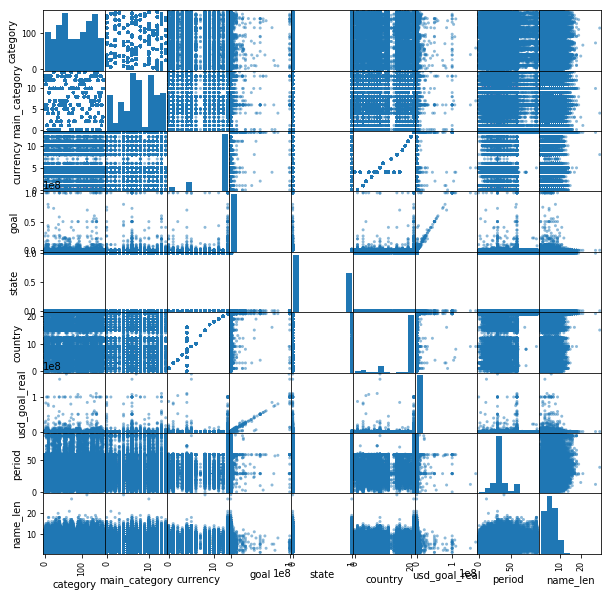

In [47]:
# 散布図行列を書いてみる
pd.plotting.scatter_matrix(df, figsize=(10,10))
plt.show()

In [ ]:
# 相関係数を確認
df.corr()

In [ ]:
# 相関係数をヒートマップにして可視化
sns.heatmap(ks_csv.corr())
plt.show()

In [6]:
# ホールドアウト法
#'state' の値をyに代入
y = df['state'].values
 #'state'以外の変数をXに代入
X = df.drop(['state'], axis=1).values
 #テストデータの割合:30%
test_size = 0.3
#訓練データとテストデータに分割、それぞれ変数に代入 ここで再現率確保のため乱数値は1234固定
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

In [7]:
# 標準化
stdsc = StandardScaler()
#トレーニングデータの標準化
X_train = stdsc.fit_transform(X_train)
#テストデータの標準化
X_test = stdsc.transform(X_test)

In [17]:
# ロジスティック回帰
#loss：損失関数　max_iter：学習の最大回数　fit_intercept：切片を求める
clf = SGDClassifier(loss='log', penalty='none',eta0=0.1, learning_rate='constant', max_iter=1000, fit_intercept=True, random_state=1234)
clf = SGDClassifier(loss='log', penalty='none',eta0=0.01, learning_rate='constant', max_iter=100, fit_intercept=True, random_state=1234)
# 学習モデル作成
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='constant', loss='log', max_iter=100, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=1234,
       shuffle=True, tol=None, verbose=0, warm_start=False)

# 訓練誤差 算出

In [16]:
# 学習用データに対する予測を実行 predictで予測
y_prd_train = clf.predict(X_train)

# 学習データに対するMAEを計算（訓練誤差の評価）
mae = mean_absolute_error(y_train, y_prd_train)
print("MAE = %s"%round(mae,3) )

MAE = 0.374


In [10]:
print(y_prd_train)
# 対数尤度 を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y_train,y_prd_train)))

# 正答率
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_train, y_prd_train)))
#適合率・再現率・F1値を計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_prd_train)
# 適合率
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
# 再現率
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
#F1値
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

[0 0 0 ... 0 0 0]
対数尤度 = -14.318
正答率（Accuracy） = 58.545%
適合率（Precision） = 63.582%
再現率（Recall） = 71.137%
F1値（F1-score） = 67.148%


# 汎化誤差　算出　

In [11]:
# テストデータに対する予測を実行
y_prd_test = clf.predict(X_test)

# テストデータに対するMAEを計算（汎化誤差の評価）
mae = mean_absolute_error(y_test, y_prd_test)
print("MAE = %s"%round(mae,3) )

MAE = 0.414


In [12]:
print(y_prd_test)
# 対数尤度 を表示
print('対数尤度 = {:.3f}'.format(-log_loss(y_test,y_prd_test)))

# 正答率
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y_test,y_prd_test)))
#適合率・再現率・F1値を計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test,y_prd_test)
# 適合率
print('適合率（Precision） = {:.3f}%'.format(100 * precision_test[0]))
# 再現率
print('再現率（Recall） = {:.3f}%'.format(100 * recall_test[0]))
#F1値
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score_test[0]))

[0 0 0 ... 0 0 0]
対数尤度 = -14.300
正答率（Accuracy） = 58.596%
適合率（Precision） = 63.739%
再現率（Recall） = 71.214%
F1値（F1-score） = 67.270%


# DAY1の結果  （訓練誤差のみ）
対数尤度 = -13.156  
正答率（Accuracy） = 61.909%  
適合率（Precision） = 63.591%  
再現率（Recall） = 84.173%  
F1値（F1-score） = 72.448%  

Recallが高いのは何に引っ張られているか見る必要あり  
今回は外れ値を考慮していないため、改善の見込みありか

# DAY2の結果  
  
訓練誤差：-14.3  
汎化誤差：-14.0  

過学習にならない。精度も良いとは言えない。  

もしかしてSGDClassifierに正則化入ってますか？  